# Label dataset for head pose

In [3]:
import os

# Define the directory containing the .jpg files
directory = 'data/AFLW2000-3D/AFLW2000'

# Function to rename files with proper ascending numbers
def rename_files(directory):
    # Get a list of all .jpg files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    # Sort the files alphabetically
    files.sort()
    
    # Initialize counter for numbering
    count = 1
    
    # Iterate through the sorted files and rename them
    for file in files:
        # Extract the file extension
        _, extension = os.path.splitext(file)
        # Define the new file name with proper ascending number
        new_name = f'image{count:05d}{extension}'
        # Rename the file
        os.rename(os.path.join(directory, file), os.path.join(directory, new_name))
        # Increment the counter
        count += 1

# Call the function to rename files in the directory
rename_files(directory)


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import psutil

def analyze_face_direction(image_path, display=True, save=True, save_path='data/labeled_AFLW2000'):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    mp_drawing = mp.solutions.drawing_utils

    image = cv2.imread(image_path)  # Read the image from file path
    if image is None:
        print(f"Error: Unable to read {image_path}. Skipping...")
        return None

    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    image.flags.writeable = False

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(image_rgb)

    image.flags.writeable = True

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    face_2d.append([x, y])
                    face_3d.append([x, y, lm.z])

            face_2d = np.array(face_2d, dtype=np.float64)
            face_3d = np.array(face_3d, dtype=np.float64)

            focal_length = 1 * img_w

            cam_matrix = np.array([[focal_length, 0, img_h / 2],
                                   [0, focal_length, img_w / 2],
                                   [0, 0, 1]])

            dist_matrix = np.zeros((4, 1), dtype=np.float64)

            success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

            rmat, jac = cv2.Rodrigues(rot_vec)

            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            x = angles[0] * 360
            y = angles[1] * 360
            z = angles[2] * 360

            if y < -10:
                text = "facing Left"
            elif y > 10:
                text = "facing Right"
            elif x < -10:
                text = "facing Down"
            elif x > 10:
                text = "facing Up"
            else:
                text = "facing Forward"

            save_dir = os.path.join(save_path, text)
            if save and not os.path.exists(save_dir):
                os.makedirs(save_dir)

            if save:
                filename = os.path.basename(image_path)  # Extract filename from input path
                save_file_path = os.path.join(save_dir, filename)
                if not os.path.exists(save_file_path):
                    cv2.imwrite(save_file_path, image)

            nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y * 10), int(nose_2d[1] - x * 10))

            cv2.line(image, p1, p2, (255, 0, 0), 3)

            target_size = (224, 224)

            font_scale_factor = 224 / 500

            font_scale = font_scale_factor * 2

            cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(image, "x: " + str(np.round(x, 2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                        (0, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(image, "y: " + str(np.round(y, 2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                        (0, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(image, "z: " + str(np.round(z, 2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                        (0, 0, 255), 1, cv2.LINE_AA)

    if display:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return image

def process_images(directory_path, save=True, save_path='data/labeled_AFLW2000', resume=True):
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} does not exist.")
        return

    if not os.path.isdir(directory_path):
        print(f"Error: {directory_path} is not a directory.")
        return

    if save and not os.path.exists(save_path):
        os.makedirs(save_path)

    last_processed_index = -1

    if resume:
        labeled_files = [file for file in os.listdir(save_path) if file.endswith('.jpg')]
        if labeled_files:
            last_file = max(labeled_files, key=lambda x: int(x.split('.')[0]))
            last_processed_index = int(last_file.split('.')[0])
        else:
            print("No labeled files found.")
            return

    files = os.listdir(directory_path)
    jpg_files = [file for file in files if file.endswith('.jpg')]

    # Start processing from the image after the last one in the labeled folder
    start_index = jpg_files.index(f"{last_processed_index + 1}.jpg") if last_processed_index != -1 else 0
    for jpg_file in jpg_files[start_index:]:
        image_path = os.path.join(directory_path, jpg_file)
        print(f"Processing {image_path}...")
        processed_image = analyze_face_direction(image_path, display=False, save=save, save_path=save_path)
        last_processed_index += 1
        # Check RAM usage
        ram_percent = psutil.virtual_memory().percent
        if ram_percent >= 80:
            print("RAM usage exceeds 80%. Restarting kernel...")
            break

        image_path = os.path.join(directory_path, jpg_file)
        print(f"Processing {image_path}...")
        processed_image = analyze_face_direction(image_path, display=False, save=save, save_path=save_path)
        if save:
            last_processed_index += 1
        # Check RAM usage
        ram_percent = psutil.virtual_memory().percent
        if ram_percent >= 80:
            print("RAM usage exceeds 80%. Pausing processing...")
            break
directory_path = "data/AFLW2000-3D/AFLW2000"
save_path = "data/labeled_AFLW2000"
process_images(directory_path, resume=True)


Processing data/AFLW2000-3D/AFLW2000\image00001.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00002.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00003.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00004.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00005.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00006.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00007.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00008.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00009.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00010.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00011.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00012.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00013.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00014.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00015.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00016.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00017.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00018.jpg...
Processing

Processing data/AFLW2000-3D/AFLW2000\image00001.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00002.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00003.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00004.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00005.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00006.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00007.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00008.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00009.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00010.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00011.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00012.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00013.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00014.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00015.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00016.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00017.jpg...
Processing data/AFLW2000-3D/AFLW2000\image00018.jpg...
Processing

KeyboardInterrupt: 

# Load dataset for head pose est

In [1]:
import os
import cv2
import numpy as np
from scipy.io import loadmat

def load_images_from_folder(folder):
    images = []
    try:
        if not os.path.exists(folder):
            print("Error: Folder '{}' does not exist.".format(folder))
            return images
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            if os.path.isfile(img_path) and filename.endswith('.jpg'):
                images.append(img_path)
    except Exception as e:
        print("Error loading images from folder '{}': {}".format(folder, str(e)))
    return images

def preprocess_images_batch(image_paths, target_size):
    processed_images = []
    try:
        for img_path in image_paths:
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image to target size
                resized_img = cv2.resize(img, target_size)
                # Normalize pixel values to range [0, 1]
                normalized_img = resized_img.astype(np.float32) / 255.0
                processed_images.append(normalized_img)
            else:
                print("Error loading image:", img_path)
    except MemoryError as mem_err:
        print("Memory error occurred during preprocessing:", str(mem_err))
    except Exception as e:
        print("Error preprocessing images: {}".format(str(e)))
    return np.array(processed_images)

aflw2000_lp_folder = 'data\AFLW2000-3D\AFLW2000'  # AFLW2000-LP dataset folder

# Define target size for resizing
target_size = (224, 224)  # Example size, adjust as needed


# Load images from AFLW2000-LP dataset (JPEG images)
aflw2000_lp_images = load_images_from_folder(aflw2000_lp_folder)

if len(aflw2000_lp_images) == 0:
    print("Warning: No images found in AFLW2000-LP dataset folder.")

# Preprocess images in batches
batch_size = 32  # Adjust batch size based on available memory
aflw2000_lp_processed_images = []


# Preprocess AFLW2000-LP dataset images
for i in range(0, len(aflw2000_lp_images), batch_size):
    batch_paths = aflw2000_lp_images[i:i+batch_size]
    batch_processed_images = preprocess_images_batch(batch_paths, target_size)
    aflw2000_lp_processed_images.extend(batch_processed_images)

aflw2000_lp_processed_images = np.array(aflw2000_lp_processed_images)

print("AFLW2000-LP dataset images preprocessed:", aflw2000_lp_processed_images.shape)

AFLW2000-LP dataset images preprocessed: (2000, 224, 224, 3)


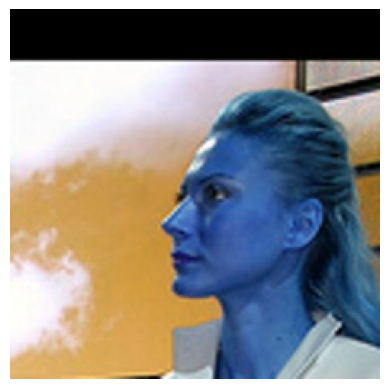

In [2]:
import matplotlib.pyplot as plt

# Assuming aflw2000_lp_processed_images is already populated

# Display the first preprocessed image
if len(aflw2000_lp_processed_images) > 0:
    first_image = aflw2000_lp_processed_images[1]
    plt.imshow(first_image)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("No preprocessed images available.")


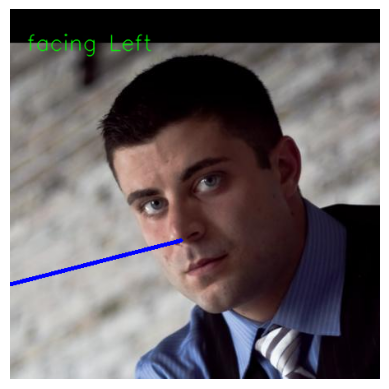

In [14]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

import os
import time

def analyze_face_direction(image_path, display=True, save=True, save_path='data/labeled_AFLW2000'):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    mp_drawing = mp.solutions.drawing_utils
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

    image = cv2.imread(image_path)  # Read the image from file path
    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    # To improve performance
    image.flags.writeable = False

    # Convert the color space from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the result
    results = face_mesh.process(image_rgb)

    # To improve performance
    image.flags.writeable = True

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    # Get the 2D Coordinates
                    face_2d.append([x, y])

                    # Get the 3D Coordinates
                    face_3d.append([x, y, lm.z])       

            # Convert it to the NumPy array
            face_2d = np.array(face_2d, dtype=np.float64)

            # Convert it to the NumPy array
            face_3d = np.array(face_3d, dtype=np.float64)

            # The camera matrix
            focal_length = 1 * img_w

            cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                    [0, focal_length, img_w / 2],
                                    [0, 0, 1]])

            # The distortion parameters
            dist_matrix = np.zeros((4, 1), dtype=np.float64)

            # Solve PnP
            success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

            # Get rotational matrix
            rmat, jac = cv2.Rodrigues(rot_vec)

            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            # Get the y rotation degree
            x = angles[0] * 360
            y = angles[1] * 360
            z = angles[2] * 360

            # See where the user's head tilting
            if y < -10:
                text = "facing Left"
            elif y > 10:
                text = "facing Right"
            elif x < -10:
                text = "facing Down"
            elif x > 10:
                text = "facing Up"
            else:
                text = "facing Forward"

            # Create directory if it doesn't exist
            save_dir = os.path.join(save_path, text)
            if save and not os.path.exists(save_dir):
                os.makedirs(save_dir)

            if save:
                # Generate unique filename
                timestamp = int(time.time())
                filename = f"{timestamp}.jpg"
                save_path = os.path.join(save_dir, filename)
                # Save the processed image
                cv2.imwrite(save_path, image)

            # Display the nose direction
            nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - x * 10))

            cv2.line(image, p1, p2, (255, 0, 0), 3)

            # Define target size for resizing
            target_size = (224, 224)

            # Define font scale factor (adjust as needed)
            font_scale_factor = 224 / 500  # 500 is just an example font scale

            # Calculate the font scale based on the target size and font scale factor
            font_scale = font_scale_factor * 2  # You can adjust 2 to your desired font scale

            # Add the text on the image with modified font
            cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(image, "x: " + str(np.round(x,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(image, "y: " + str(np.round(y,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.putText(image, "z: " + str(np.round(z,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), 1, cv2.LINE_AA)

    if display:
        # Display the image using Matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axis
        plt.show()

    return image

# Example usage:
# Assuming aflw2000_lp_processed_images is already populated
image_path = "data\AFLW2000-3D\AFLW2000\image00020.jpg"  # Replace "your_image.jpg" with the actual file name
processed_image = analyze_face_direction(image_path)
